# PROJECT : Predicting Health Insurance OLS Model, Feature Engineering and Selection Using VIF and Correlation

## Project Overview
This project aims to predict health insurance charges using regression analysis. We perform **feature engineering** to create new variables such as polynomial and interaction terms, and apply **binary encoding** for categorical features. We also assess **multicollinearity** among predictors using **Variance Inflation Factor (VIF)** and explore correlations to select the most important features for the model.

## Goal
The goal is to build an accurate and interpretable **OLS regression model** that identifies key factors influencing health insurance costs, while ensuring the predictors are meaningful and not highly correlated.


In [26]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [27]:
df = pd.read_csv('insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [28]:
df.shape

(1338, 7)

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [30]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


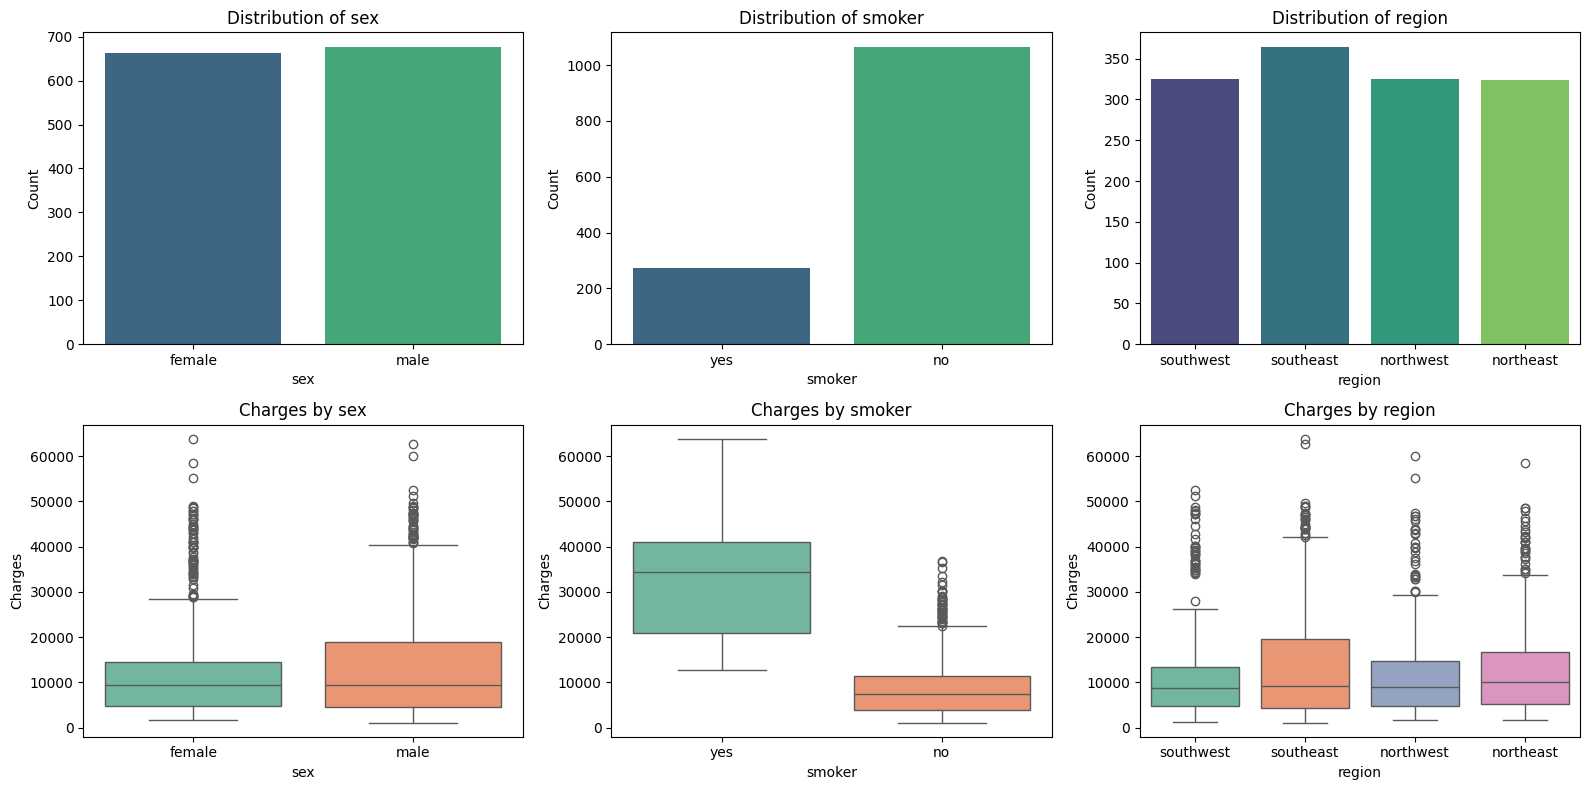

In [31]:
cat_cols = ["sex", "smoker", "region"]

fig, axes = plt.subplots(2, 3, figsize=(16, 8))

# Countplots
for i, col in enumerate(cat_cols):
    sns.countplot(data=df, x=col, palette="viridis", ax=axes[0, i])
    axes[0, i].set_title(f"Distribution of {col}")
    axes[0, i].set_xlabel(col)
    axes[0, i].set_ylabel("Count")

# Boxplots
for i, col in enumerate(cat_cols):
    sns.boxplot(data=df, x=col, y="charges", palette="Set2", hue=None, ax=axes[1, i])
    axes[1, i].set_title(f"Charges by {col}")
    axes[1, i].set_xlabel(col)
    axes[1, i].set_ylabel("Charges")

plt.tight_layout()
plt.show()


# Feature Engineering

We create new features to enhance the regression model

In [32]:
df["bmi_sq"] = df["bmi"]**2
df["age_bmi"] = df["age"] * df["bmi"]
def binary_encode(df, col, positive_val):
    return df[col].apply(lambda x: 1 if x == positive_val else 0)

df["smoker_bin"] = binary_encode(df, "smoker", "yes")
df["age_smoker"] = df["age"] * df["smoker_bin"]

In [9]:
df.head()

,age,sex,bmi,children,smoker,region,charges,bmi_sq,age_bmi,smoker_bin,age_smoker
0,19,female,27.900,0,yes,southwest,16884.92400,778.410000,530.100,1,19
1,18,male,33.770,1,no,southeast,1725.55230,1140.412900,607.860,0,0
2,28,male,33.000,3,no,southeast,4449.46200,1089.000000,924.000,0,0
3,33,male,22.705,0,no,northwest,21984.47061,515.517025,749.265,0,0
4,32,male,28.880,0,no,northwest,3866.85520,834.054400,924.160,0,0


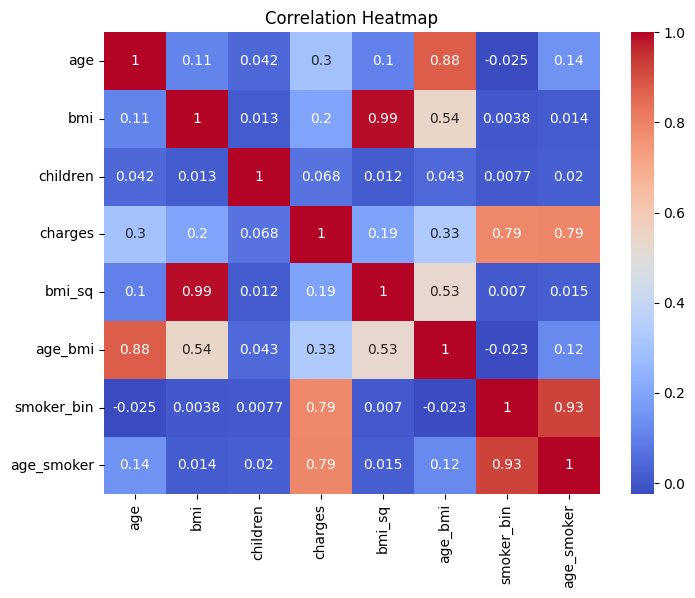

In [10]:
corr = df.corr(numeric_only=True)
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# Checking Multicollinearity using VIF

We calculate the **Variance Inflation Factor (VIF)** to check for multicollinearity among the features.  

- **Features considered**: age, bmi, children, age_smoker
- **VIF** quantifies how much the variance of a regression coefficient is inflated due to multicollinearity.  
  - **VIF 1 - 5** - Good
  - **VIF > 5** - Intermediate
  - **VIF > 10** - high multicollinearity, suggesting the feature may need to be removed or combined.  


In [33]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_vif = df[["age", "bmi", "children", "age_smoker"]]
vif = pd.DataFrame()
vif["Feature"] = X_vif.columns
vif["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
print(vif)

      Feature       VIF
0         age  7.735709
1         bmi  7.848081
2    children  1.797099
3  age_smoker  1.247528


In [34]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import statsmodels.formula.api as smf

In [35]:
X = df.drop(columns=["charges"])
y = df["charges"]

cat_cols = ["sex", "smoker", "region"]
num_cols = [c for c in X.columns if c not in cat_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Define preprocessing pipeline

In [36]:
preprocess = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(drop="first"), cat_cols)
])

## Regression Model Evaluation

We are evaluating multiple regression models on our dataset using a pipeline that includes preprocessing and the model itself. The metrics calculated are RMSE, MSE, MAE, and R².


In [37]:
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.01),
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "SVR": SVR()
}

results = []

for name, model in models.items():
    pipe = Pipeline([("prep", preprocess), ("model", model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append([name, rmse, mse, mae, r2])

results_df = pd.DataFrame(results, columns=["Model", "RMSE", "MSE", "MAE", "R2"])
print(results_df)

              Model          RMSE           MSE          MAE        R2
0  LinearRegression   5873.718241  3.450057e+07  4338.780845  0.777772
1             Ridge   5861.623139  3.435863e+07  4321.121265  0.778687
2             Lasso   5873.684947  3.450017e+07  4338.737472  0.777775
3      RandomForest   4503.905432  2.028516e+07  2442.211589  0.869338
4  GradientBoosting   4339.138471  1.882812e+07  2472.152760  0.878723
5               SVR  12864.589500  1.654977e+08  8581.012928 -0.066016


# Cross-Validation Performance
To evaluate model generalization, we perform **5-fold cross-validation** for each model.  

- **Why CV?** A single train/test split may give biased results.  
- **R² mean** → Average explanatory power of the model across folds.  
- **R² std** → Variation across folds (lower is better, means model is more stable).  


In [39]:
from sklearn.model_selection import cross_val_score

for name, model in models.items():
    pipe = Pipeline([("prep", preprocess), ("model", model)])
    scores = cross_val_score(pipe, X, y, cv=5, scoring="r2")
    print(f"{name}: R2 mean={scores.mean():.3f}, std={scores.std():.3f}")


LinearRegression: R2 mean=0.747, std=0.023
Ridge: R2 mean=0.747, std=0.023
Lasso: R2 mean=0.747, std=0.023
RandomForest: R2 mean=0.838, std=0.033
GradientBoosting: R2 mean=0.853, std=0.032
SVR: R2 mean=-0.097, std=0.012


# OLS Regression using Formula
We fit an **Ordinary Least Squares (OLS) regression** model using the formula interface.  

The model equation is:

\[
charges ~ age + bmi + children + bmi\_sq + age\_bmi + age\_smoker + C(sex) + C(smoker) + C(region)
\]

- **charges** → target variable  
- **age, bmi, children** → numeric predictors  
- **bmi_sq, age_bmi, age_smoker** → engineered interaction features  
- **C(sex), C(smoker), C(region)** → categorical variables encoded as dummy variables  

This allows us to interpret regression coefficients directly in terms of the predictors.


In [40]:
formula = "charges ~ age + bmi + children + bmi_sq + age_bmi + age_smoker + C(sex) + C(smoker) + C(region)"
ols = smf.ols(formula=formula, data=df).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     366.1
Date:                Sun, 07 Sep 2025   Prob (F-statistic):               0.00
Time:                        08:36:38   Log-Likelihood:                -13544.
No. Observations:                1338   AIC:                         2.711e+04
Df Residuals:                    1326   BIC:                         2.717e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -1.78

# Residuals vs Predicted
We visualize residuals against predicted values to detect heteroscedasticity (unequal variance). Ideally, points should be randomly scattered around zero.


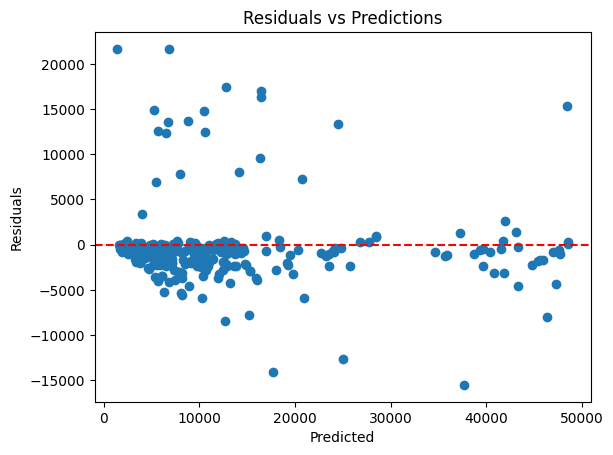

In [19]:
best_model = RandomForestRegressor(n_estimators=200, random_state=42)
pipe = Pipeline([("prep", preprocess), ("model", best_model)])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted"); plt.ylabel("Residuals")
plt.title("Residuals vs Predictions")
plt.show()


# Residuals Distribution
We check if residuals follow a roughly normal distribution. A bell-shaped curve indicates that model assumptions hold.


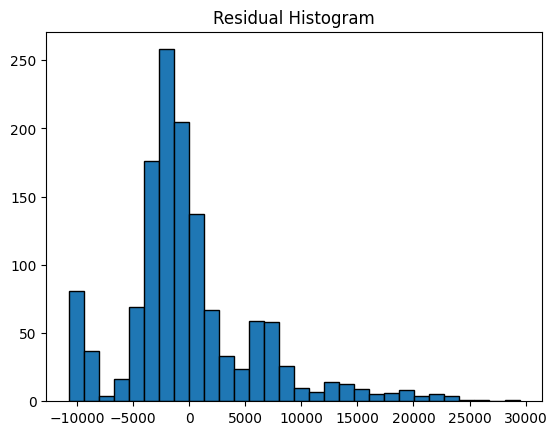

In [20]:
plt.hist(ols.resid, bins=30, edgecolor="k")
plt.title("Residual Histogram")
plt.show()

# QQ Plot of Residuals
The QQ (Quantile-Quantile) plot compares residuals against a normal distribution.  
If residuals are normally distributed, points will follow the 45° diagonal line.


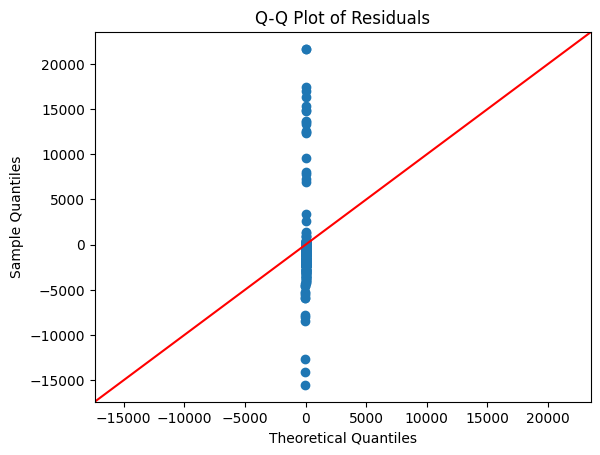

In [41]:
import scipy.stats as stats
import statsmodels.api as sm
sm.qqplot(residuals, line="45")
plt.title("Q-Q Plot of Residuals")
plt.show()

# Feature Importance (Tree-Based Model)
Tree-based models (like Gradient Boosting) provide feature importances. This helps us understand which variables influence charges the most.


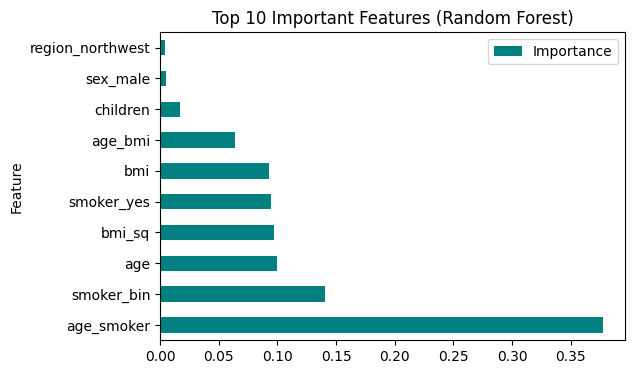

In [42]:
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(preprocess.fit_transform(X_train), y_train)

importances = rf.feature_importances_
feature_names = num_cols + list(preprocess.named_transformers_['cat'].get_feature_names_out(cat_cols))
feat_imp = pd.DataFrame({"Feature": feature_names, "Importance": importances})
feat_imp.sort_values("Importance", ascending=False).head(10).plot(
    kind="barh", x="Feature", y="Importance", figsize=(6,4), color="teal"
)
plt.title("Top 10 Important Features (Random Forest)")
plt.show()


# Final Model Comparison
We compare all models (Linear Regression, Ridge, Lasso, Random Forest, Gradient Boosting, SVR) based on RMSE, MAE, MSE, and R².


In [44]:
results_df.sort_values("R2", ascending=False, inplace=True)
print("=== Final Model Performance ===")
print(results_df)


=== Final Model Performance ===
              Model          RMSE           MSE          MAE        R2
4  GradientBoosting   4339.138471  1.882812e+07  2472.152760  0.878723
3      RandomForest   4503.905432  2.028516e+07  2442.211589  0.869338
1             Ridge   5861.623139  3.435863e+07  4321.121265  0.778687
2             Lasso   5873.684947  3.450017e+07  4338.737472  0.777775
0  LinearRegression   5873.718241  3.450057e+07  4338.780845  0.777772
5               SVR  12864.589500  1.654977e+08  8581.012928 -0.066016


### Interpretation

1. **Best Performing Model:**  
   - **Gradient Boosting** has the lowest RMSE (4339.14) and MAE (2472.15), and the highest R² (0.879), indicating it predicts insurance charges most accurately.  

2. **Random Forest** is also strong, with slightly higher RMSE (4503.91) and slightly lower R² (0.869), showing it performs well but slightly less precise than Gradient Boosting.  

3. **Linear Models (LinearRegression, Ridge, Lasso):**  
   - All have similar performance (R² ~0.778), indicating moderate predictive capability.  
   - Ridge and Lasso provide slight regularization benefits but do not outperform Gradient Boosting or Random Forest.  

4. **SVR:**  
   - Performs poorly with very high RMSE (12864.59) and negative R² (-0.066), indicating the model fails to capture the underlying patterns in the data.  

**Conclusion:**  
- Tree-based ensemble models (Gradient Boosting and Random Forest) clearly outperform linear models and SVR for this dataset.  
- Gradient Boosting is recommended as the final model for predicting health insurance charges due to its superior accuracy and reliability.